In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
current_path = os.getcwd()
previous_path = os.chdir("..")
sys.path.append(current_path)
sys.path.append(previous_path)

In [8]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from data_fitting.module_fitzcu import *

from qick import *
# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

import json
import datetime
import pprint as pp

In [3]:
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

QICK running on ZCU216, software version 0.2.302

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 8192 samples (0.855 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 4096 samples (0.427 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_sg_int4_v2 - envelope memory 16384 samples (38.095 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 3

# TOF

In [4]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        qb_ch=1
        self.declare_gen(ch=gen_ch, nqz=2)
        self.declare_gen(ch=qb_ch, nqz=2)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['pulse_len'], 
                       freq=cfg['freq'], 
                       phase=cfg['pulse_phase'],
                       gain=cfg['pulse_gain'],
                      )
        
        self.add_pulse(ch=qb_ch, name="myconst1", ro_ch=ro_ch, 
                style="const", 
                length=cfg['pulse_len'], 
                freq=cfg['freq'], 
                phase=cfg['pulse_phase'],
                gain=cfg['pulse_gain'],
                )
        
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=1, name="myconst1", t=0)
        self.delay_auto(t=0.1, tag='test')
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)


config = {
    ## Channel Params. ##
    'gen_ch': 0,
    'ro_ch': 0,
    ## Pulse Params. ##
    'freq': 7100, # [MHz]
    'pulse_len': 0.2, # [us]
    'pulse_phase': 0, # [deg]
    'pulse_gain': 0.8, # [DAC units]
    ## Readout Params. ##
    'trig_time': 0, # [us]
    'ro_len': 1.3, # [us]
    'relax_delay': 0.1, # [us]
     }

###################
# Run the Program
###################

prog =LoopbackProgram(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

  0%|          | 0/10 [00:00<?, ?it/s]

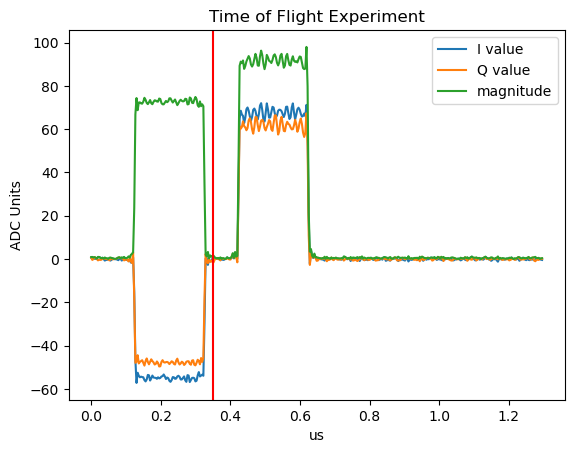

In [5]:
# Plot results.
plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("ADC Units")
plt.xlabel("us")
plt.title('Time of Flight Experiment')
######## SET THIS VALUE AS YOUR config['trig_time'] #########
plt.axvline(0.35, c='r') 
trig_time = 0.35

# Resonator Spectroscopy

In [10]:
## Using the Dynamically Configured Readout Channel ##
class SingleToneSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [11]:
START_FREQ = 4000 # [MHz]
STOP_FREQ = 5000 # [MHz]
STEPS = 1000

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points
    
    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,

    ## Resonator Pulse Params. ##
    'f_res': QickSweep1D('freqloop', START_FREQ, STOP_FREQ), # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 1.0, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.2, # [us]
    'ro_len': 1, # [us]
    'relax_delay': 10, # [us]
     }

  0%|          | 0/10 [00:00<?, ?it/s]

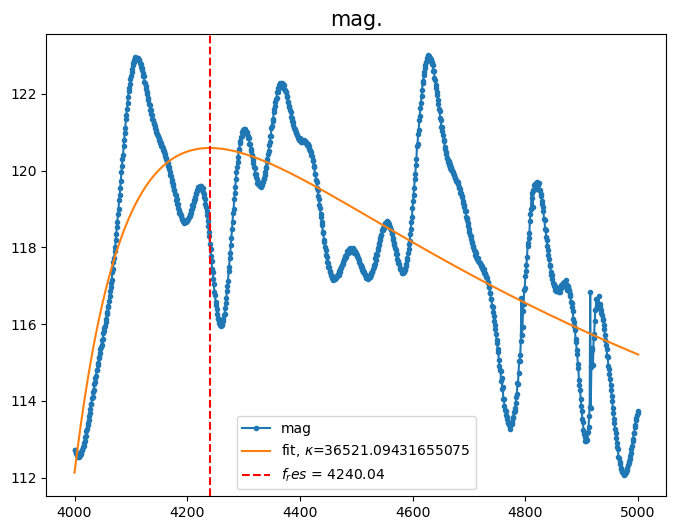

4240.04

In [12]:
prog = SingleToneSpectroscopyProgram(soccfg, reps=10, final_delay=config['relax_delay'], cfg=config)
iq_list = prog.acquire(soc, soft_avgs=10, progress=True)
freqs = prog.get_pulse_param("res_pulse", "freq", as_array=True)
res_onetone = (iq_list[0][0].dot([1,1j]))
resonator_analyze2(freqs, res_onetone)

# Resonator Punch out

In [16]:
class SingleTonePunchoutProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("gainloop", cfg["g_steps"])
        self.add_loop("freqloop", cfg["f_steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [17]:
START_FREQ = 5000 # [MHz]
STOP_FREQ = 6000 # [MHz]
STEPS_freq = 100


START_gain = 0.1 # [MHz]
STOP_gain = 0.5# [MHz]
STEPS_gain = 5


config = {
    ## Sweep Params: ##
    'f_steps': STEPS_freq, 
    'g_steps': STEPS_gain, 
    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,

    ## Resonator Pulse Params. ##
    'f_res': QickSweep1D('freqloop', START_FREQ, STOP_FREQ), # [MHz]
    'res_len': 1.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': QickSweep1D('gainloop', START_gain, STOP_gain), # [DAC units]

    ## Readout Params. ##
    'trig_time': trig_time, # [us]
    'ro_len': 1, # [us]
    'relax_delay': 0.5, # [us]
     }

In [18]:
prog = SingleTonePunchoutProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
freqs = prog.get_pulse_param("res_pulse", "freq", as_array=True)
gains = prog.get_pulse_param("res_pulse", "gain", as_array=True)
res_punchout = iq_list[0][0].dot([1,1j])


  0%|          | 0/50000 [00:00<?, ?it/s]

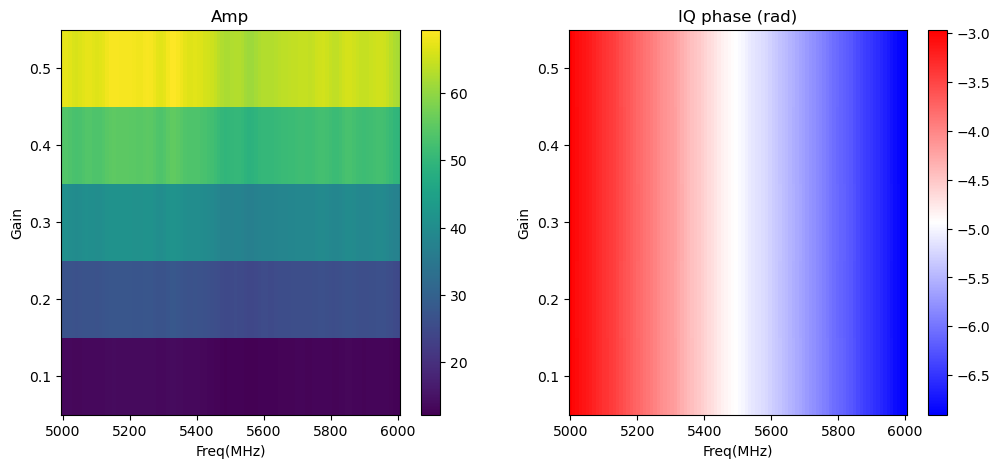

In [19]:
avg_abs, avg_angle = np.abs(res_punchout), np.angle(res_punchout)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, d in enumerate([avg_abs, avg_angle]):
    if i==0:
        pcm = axes[i].pcolormesh(freqs,gains, d, shading="Auto")
    else:
        pcm = axes[i].pcolormesh(freqs, gains, np.unwrap(d), shading="Auto", cmap="bwr")
    axes[i].set_ylabel("Gain")
    axes[i].set_xlabel("Freq(MHz)")
    axes[i].set_title("Amp" if i ==0  else "IQ phase (rad)")
    plt.colorbar(pcm, ax=axes[i])

# Qubit spectroscopy

In [20]:
class PulseProbeSpectroscopyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("freqloop", cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['probe_len'], 
                       freq=cfg['f_ge'], 
                       phase= 0,
                       gain=cfg['qubit_gain'],
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0) 
        self.delay_auto(t=0.05, tag='wait')
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [21]:
START_FREQ = 4000 # [MHz]
STOP_FREQ = 4500 # [MHz]
STEPS = 101

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
    ## Resonator Pulse Params. ##
    'f_res':  5000, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain':1.0, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 1000, # [us]
    
    ## Qubit Params. ##
    'f_ge': QickSweep1D('freqloop', START_FREQ, STOP_FREQ), # [MHz]
    "probe_len": 15, # [us]
    "qubit_gain": 0.01, # [DAC units]
     }


  0%|          | 0/101000 [00:00<?, ?it/s]

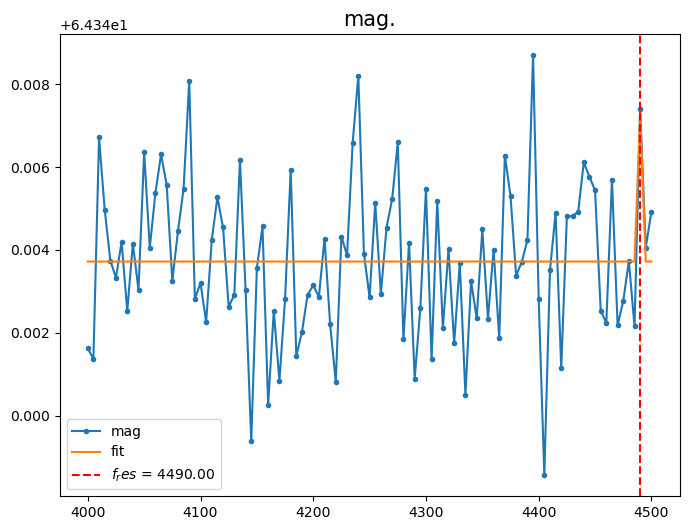

4490.0

In [22]:
qspec=PulseProbeSpectroscopyProgram(soccfg, reps=1000, final_delay= 0.5, cfg=config)
iq_list = qspec.acquire(soc, soft_avgs=1, progress=True)
freqs = qspec.get_pulse_param('qubit_pulse', "freq", as_array=True)
qb_spec = iq_list[0][0].dot([1,1j])
spectrum_analyze(freqs, qb_spec)

# Length Rabi

In [236]:

class LengthRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)


        self.add_loop("lenloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['probe_len'], 
                       freq=cfg['f_ge'], 
                       phase= cfg['qubit_phase'],
                       gain=cfg['qubit_gain'],
                      )
        
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse

        self.delay_auto(t=0.0, tag='waiting')
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


In [ ]:
START_LEN = 0.02 # [us]
STOP_LEN = 5 # [us]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
    ## Resonator Pulse Params. ##
    'f_res': 7149.742, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.5, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 10.0, # [us]
    'relax_delay': 1000, # [us]
    
    ## Qubit Params. ##
    'f_ge': 2963.814, # [MHz]
    "probe_len": QickSweep1D('lenloop', START_LEN, STOP_LEN), # [us]
    'qubit_phase': 0, # [deg]
    "qubit_gain":0.2, # [DAC units]
     }



  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
prog = LengthRabiProgram(soccfg,reps=1,final_delay=config['relax_delay'], cfg=config)
iq_list = prog.acquire(soc, soft_avgs=10)
t = prog.get_pulse_param('qubit_pulse', "length", as_array=True)
length_rabi = iq_list[0][0].dot([1,1j])

# lengthrabi_analyze(t, length_rabi.real)

# Power Rabi

In [42]:
class AmplitudeRabiProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("gainloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=False)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['qubit_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg["qubit_ch"], name="qubit_pulse", t=0)  #play probe pulse
        
        self.delay_auto(t=0.05, tag='waiting')

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t = 0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [47]:
START_GAIN = 0.0 # [DAC units]
STOP_GAIN = 0.5 # [DAC units]
STEPS = 200

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 0,
    
    ## Resonator Pulse Params. ##
    'f_res': 5000, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.1, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 50, # [us]
    
    ## Qubit Params. ##
    'f_ge': 4000, # [MHz]
    'qubit_phase': 0, # [deg]
    "qubit_gain":QickSweep1D('gainloop', START_GAIN, STOP_GAIN), # [DAC units]
    'sigma': 1.0 / 5, # [us]
     }


In [48]:
amp_rabi=AmplitudeRabiProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
iq_list = np.array(amp_rabi.acquire(soc, soft_avgs=1, progress=True))
gains = amp_rabi.get_pulse_param('qubit_pulse', "gain", as_array=True)
power_rabi = iq_list[0][0].dot([1,1j])

# amprabi_analyze(gains, power_rabi)

  0%|          | 0/20000 [00:00<?, ?it/s]

# Ramsey Fringe Experiment

In [ ]:
class RamseyProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi2_gain'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['pi2_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
START_TIME = 0.0 # [us]
STOP_TIME = 100 # [us]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
   ## Resonator Pulse Params. ##
    'f_res': 5000, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.1, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 10, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': 4000, # [MHz]
    "pi_gain":  0.2, # [DAC units]
    "pi2_gain": 0.2 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 1.0 / 5,
    'ramsey_freq': 2, # [MHz]
     }



In [ ]:
ramsey=RamseyProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
iq_list = ramsey.acquire(soc, soft_avgs=py_avg, progress=True)
delay_times = ramsey.get_time_param('wait', "t", as_array=True)
ramsey = iq_list[0][0].dot([1,1j])

T2fring_analyze(delay_times, ramsey)

# Spin Echo Experiment

In [ ]:
class SpinEchoProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)
        
        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse1", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi2_gain'], 
                      )
        
        # pi pulse
        self.add_pulse(ch=qubit_ch, name="qubit_pulse_pi", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
        
        self.add_pulse(ch=qubit_ch, name="qubit_pulse2", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'] + cfg['wait_time']*360*cfg['ramsey_freq'], # current phase + time * 2pi * ramsey freq
                       gain=cfg['pi2_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse1", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait1') # wait_time after last pulse (wait / 2)
        
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse_pi", t=0)  #play pulse
        
        self.delay_auto((cfg['wait_time']/2)+0.01, tag = 'wait2') # wait_time after last pulse (wait / 2)

        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse2", t=0)  #play pulse

        self.delay_auto(0.01) # wait_time after last pulse
        
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
START_TIME = 0.0 # [us]
STOP_TIME = 100 # [us]
STEPS = 100

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
   ## Resonator Pulse Params. ##
    'f_res': 5000, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.1, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 1000, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': 4000, # [MHz]
    "pi_gain":  0.2, # [DAC units]
    "pi2_gain": 0.2 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 1.0 / 5,
    'ramsey_freq': 5, # [MHz]
     }

In [ ]:
se=SpinEchoProgram(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
iq_list = se.acquire(soc, soft_avgs=1, progress=True)
delay_times1 = se.get_time_param('wait1', "t", as_array=True)
delay_times2 = se.get_time_param('wait2', "t", as_array=True)
spinecho = iq_list[0][0].dot([1,1j])

T2fring_analyze(delay_times1+delay_times2, spinecho)


# T1

In [6]:
class T1Program(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)
        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)


        self.add_loop("waitloop", cfg["steps"])
        
        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain=cfg['pi_gain'], 
                      )
    
    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        
        self.delay_auto(cfg['wait_time']+0.01, tag='wait') # wait_time after last pulse

        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [10]:
START_TIME = 0.0 # [us]
STOP_TIME = 500.0 # [us]
STEPS = 50

config = {
    ## Sweep Params: ##
    'steps': STEPS, # Number of sweep points

    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
   ## Resonator Pulse Params. ##
    'f_res': 5000, # [MHz]
    'res_len': 2.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.1, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 4.0, # [us]
    'relax_delay': 100, # [us]
    'wait_time': QickSweep1D('waitloop', START_TIME, STOP_TIME), # [us]

    ## Qubit Params. ##
    'f_ge': 4000, # [MHz]
    "pi_gain": 0.2, # [DAC units]
    "pi2_gain": 0.2 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 0.1 / 5,
     }


  0%|          | 0/10 [00:00<?, ?it/s]

d:\Anaconda3\envs\labberenv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


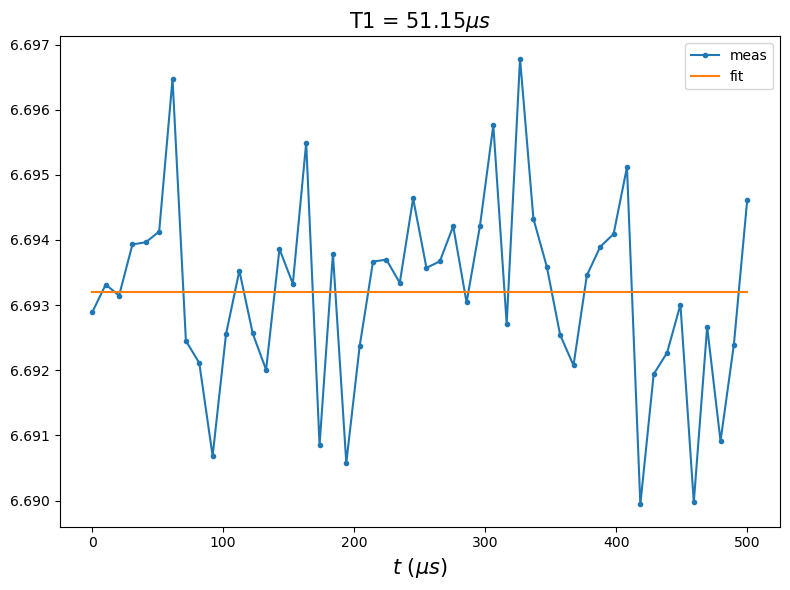

In [11]:
t1=T1Program(soccfg, reps=100, final_delay=config['relax_delay'], cfg=config)
iq_list = t1.acquire(soc, soft_avgs=10, progress=True)
delay_times = t1.get_time_param('wait', "t", as_array=True)
t1 = iq_list[0][0].dot([1,1j])

T1_analyze(delay_times, t1)

# Single shot

In [52]:
# Separate g and e per each experiment defined.

class SingleShotProgram_g(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)

        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots

        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        # no qubit pulse
        self.delay_auto(0.01, tag='wait')
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])


class SingleShotProgram_e(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        res_ch = cfg['res_ch']
        qubit_ch = cfg['qubit_ch']
        
        self.declare_gen(ch=res_ch, nqz=2)
        self.declare_gen(ch=qubit_ch, nqz=1)

        # pynq configured
        # self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['f_res'], gen_ch=res_ch)
        
        # tproc configured
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['f_res'], gen_ch=res_ch)

        self.add_loop("shotloop", cfg["steps"]) # number of total shots

        self.add_pulse(ch=res_ch, name="res_pulse", ro_ch=ro_ch, 
                       style="const", 
                       length=cfg['res_len'], 
                       freq=cfg['f_res'], 
                       phase=cfg['res_phase'],
                       gain=cfg['res_gain'],
                      )
        
        self.add_gauss(ch=qubit_ch, name="ramp", sigma=cfg['sigma'], length=cfg['sigma']*5, even_length=True)
        self.add_pulse(ch=qubit_ch, name="qubit_pulse", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['f_ge'], 
                       phase=cfg['qubit_phase'],
                       gain= cfg['pi_gain'], 
                      )

    def _body(self, cfg):
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=self.cfg["qubit_ch"], name="qubit_pulse", t=0)  #play pulse
        self.delay_auto(0.01, tag='wait')
        self.pulse(ch=cfg['res_ch'], name="res_pulse", t=0) # play probe pulse
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [57]:
SHOTS = 2000

config = {
    ## Sweep Params: ##
    'steps': SHOTS, # Number of shot points (outer loop)
    
    ## Channel Params. ##
    'res_ch': 0,
    'ro_ch': 0,
    'qubit_ch': 1,
    
    ## Resonator Pulse Params. ##
    'f_res': 5000, # [MHz]
    'res_len': 6.0, # [us]
    'res_phase': 0, # [deg]
    'res_gain': 0.1, # [DAC units]

    ## Readout Params. ##
    'trig_time': 0.65, # [us]
    'ro_len': 8.0, # [us]
    'relax_delay': 10, # [us]

    ## Qubit Params. ##
    'f_ge': 4000, # [MHz]
    "pi_gain": 0.2, # [DAC units]
    "pi2_gain": 0.2 / 2, # [DAC units]
    'qubit_phase': 0,
    'sigma': 0.05,
     }


ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=True)

ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Optimal fidelity after rotation = 0.059


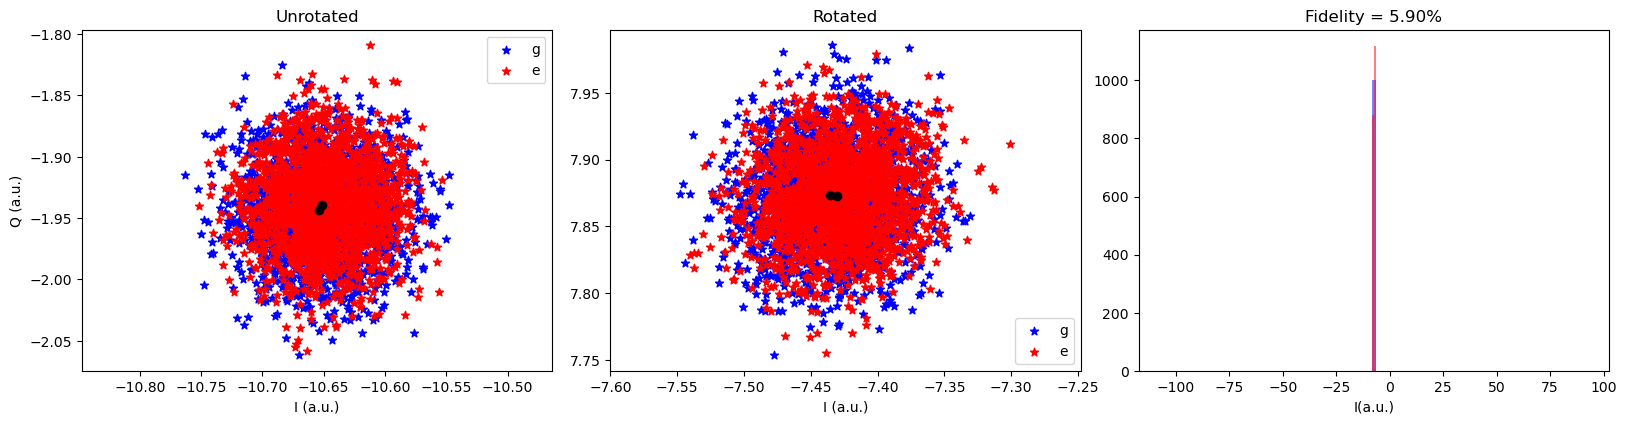

In [58]:
I_g = iq_list_g[0][0].T[0]
Q_g = iq_list_g[0][0].T[1]
I_e = iq_list_e[0][0].T[0]
Q_e = iq_list_e[0][0].T[1]

fid, threshold, angle = hist(data=[I_g, Q_g, I_e, Q_e],  plot=True, ran=100)
print('Optimal fidelity after rotation = %.3f' % fid)
# readout_cfg["res_phase"]=soccfg.deg2reg(-angle*180/pi, gen_ch=5)
# readout_cfg["threshold"]=round(threshold)

## Readout Optimization

## Gain VS Frequency

In [62]:
freq_steps = 10
freq_step_size = 0.1 # [MHz]
freq_start = (5000) - ((freq_steps/2)*freq_step_size)
gain_steps = 10
gain_step_size = 0.1 # [DAC units]
gain_start = 0
SHOTS = 10

I_g_array = []
Q_g_array = []
I_e_array = []
Q_e_array = []

for freqs in range(freq_steps):
    I_g_data = []
    Q_g_data = []
    I_e_data = []
    Q_e_data = []
    for gains in range(gain_steps):
        config = {
            ## Sweep Params: ##
            'steps': SHOTS, # Number of shot points (outer loop)
            
            ## Channel Params. ##
            'res_ch': 0,
            'ro_ch': 0,
            'qubit_ch': 1,
            
            ## Resonator Pulse Params. ##
            'f_res': freq_start + freq_step_size*freqs, # [MHz]
            'res_len': 2.0, # [us]
            'res_phase': 0, # [deg]
            'res_gain': gain_start + gain_step_size*gains, # [DAC units]

            ## Readout Params. ##
            'trig_time': 0.65, # [us]
            'ro_len': 4.0, # [us]
            'relax_delay': 10, # [us]

            ## Qubit Params. ##
            'f_ge': 4000, # [MHz]
            "pi_gain": 0.1, # [DAC units]
            "pi2_gain": 0.1 / 2, # [DAC units]
            'qubit_phase': 0,
            'sigma': 0.1 / 5,
            }

        ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=False)

        ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=False)

        I_g = iq_list_g[0][0].T[0]
        Q_g = iq_list_g[0][0].T[1]
        I_e = iq_list_e[0][0].T[0]
        Q_e = iq_list_e[0][0].T[1]
    
        I_g_data.append([I_g])
        Q_g_data.append([Q_g])
        I_e_data.append([I_e])
        Q_e_data.append([Q_e])

    I_g_array.append([I_g_data])
    Q_g_array.append([Q_g_data])
    I_e_array.append([I_e_data])
    Q_e_array.append([Q_e_data])


C:\Users\SQC\AppData\Local\Temp\ipykernel_10896\2030140156.py:30: UserWarning: The following kwargs were not used by contour: 'interpolation'
  figB = plt.contour(gains_list,freqs_list,fid_Array, 10 ,colors='w',interpolation='none')


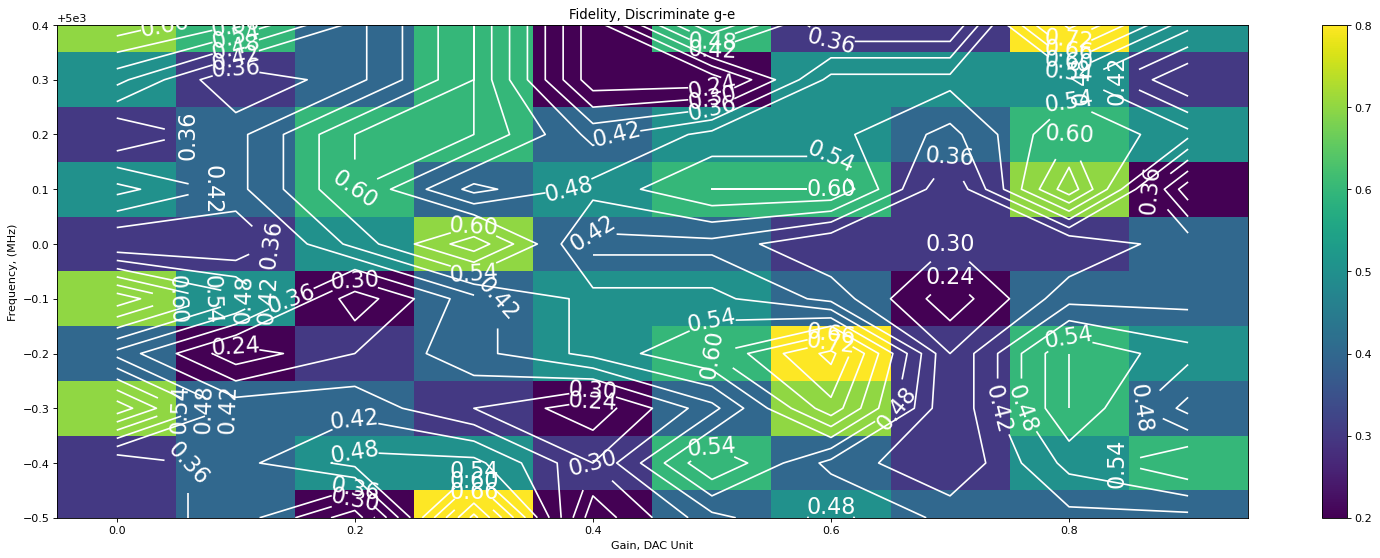

In [63]:
fid_Array =np.zeros([freq_steps,gain_steps])
for index_freq in range(freq_steps):
    for index_amp in range(gain_steps):
        I_g = I_g_array[index_freq][0][index_amp][0]
        Q_g = Q_g_array[index_freq][0][index_amp][0]
        I_e = I_e_array[index_freq][0][index_amp][0]
        Q_e = Q_e_array[index_freq][0][index_amp][0]
        vec_I = np.mean(I_e) - np.mean(I_g)
        vec_Q = np.mean(Q_e) - np.mean(Q_g)
        gstate = (I_g - np.mean(I_g))*vec_I + (Q_g - np.mean(Q_g))*vec_Q
        estate = (I_e - np.mean(I_g))*vec_I + (Q_e - np.mean(Q_g))*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2

        th_min = min(gstate)
        th_max = max(estate)
        th_list = np.linspace(th_min,th_max,1000)
        fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
        fid_Array[index_freq,index_amp] = max(fidelity)*2-1

freqs_list = np.zeros(freq_steps)
gains_list = np.zeros(gain_steps)
for gain in range(gain_steps):
    gains_list[gain] = gain_start + gain_step_size*gain
for freq in range(freq_steps):
    freqs_list[freq] = freq_start + freq_step_size*freq

plt.figure(figsize=(24, 8), dpi=80)
figA = plt.pcolormesh(gains_list,freqs_list,fid_Array)
figB = plt.contour(gains_list,freqs_list,fid_Array, 10 ,colors='w',interpolation='none')
plt.clabel(figB, figB.levels, inline=True, fontsize=20)
plt.xlabel(r"Gain, DAC Unit")
plt.ylabel(r"Frequency, (MHz)")
plt.title(r"Fidelity, Discriminate g-e")
plt.colorbar(figA)
plt.show()
#plt.savefig("FidwithoutJPA.png",dpi=300,bbox_inches='tight')

### Length VS Frequency

In [64]:
freq_steps = 10
freq_step_size = 0.05 # [MHz]
freq_start = (5000) - ((freq_steps/2)*freq_step_size)
length_steps = 10
length_step_size = 0.3 # [us units]
length_start = 2.0
SHOTS = 10

I_g_array = []
Q_g_array = []
I_e_array = []
Q_e_array = []

for freqs in range(freq_steps):
    I_g_data = []
    Q_g_data = []
    I_e_data = []
    Q_e_data = []
    for lengths in range(gain_steps):
        config = {
            ## Sweep Params: ##
            'steps': SHOTS, # Number of shot points (outer loop)
            
            ## Channel Params. ##
            'res_ch': 0,
            'ro_ch': 0,
            'qubit_ch': 1,
            
            ## Resonator Pulse Params. ##
            'f_res': freq_start + freq_step_size*freqs, # [MHz]
            'res_len': length_start + length_step_size*lengths, # [us]
            'res_phase': 0, # [deg]
            'res_gain': 0.1, # [DAC units]

            ## Readout Params. ##
            'trig_time': 0.65, # [us]
            'ro_len': length_start + length_step_size*lengths + 2.0, # [us]
            'relax_delay': 1000, # [us]

            ## Qubit Params. ##
            'f_ge': 4000, # [MHz]
            "pi_gain": 0.1, # [DAC units]
            "pi2_gain": 0.1 / 2, # [DAC units]
            'qubit_phase': 0,
            'sigma': 0.1 / 5,
            }

        ssp_g = SingleShotProgram_g(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_g = ssp_g.acquire(soc, soft_avgs=1, progress=False)

        ssp_e = SingleShotProgram_e(soccfg, reps=1, final_delay=config['relax_delay'], cfg=config)
        iq_list_e = ssp_e.acquire(soc, soft_avgs=1, progress=False)

        I_g = iq_list_g[0][0].T[0]
        Q_g = iq_list_g[0][0].T[1]
        I_e = iq_list_e[0][0].T[0]
        Q_e = iq_list_e[0][0].T[1]
    
        I_g_data.append([I_g])
        Q_g_data.append([Q_g])
        I_e_data.append([I_e])
        Q_e_data.append([Q_e])

    I_g_array.append([I_g_data])
    Q_g_array.append([Q_g_data])
    I_e_array.append([I_e_data])
    Q_e_array.append([Q_e_data])


C:\Users\SQC\AppData\Local\Temp\ipykernel_10896\2401268150.py:30: UserWarning: The following kwargs were not used by contour: 'interpolation'
  figB = plt.contour(lengths_list,freqs_list,fid_Array, 10 ,colors='w',interpolation='none')


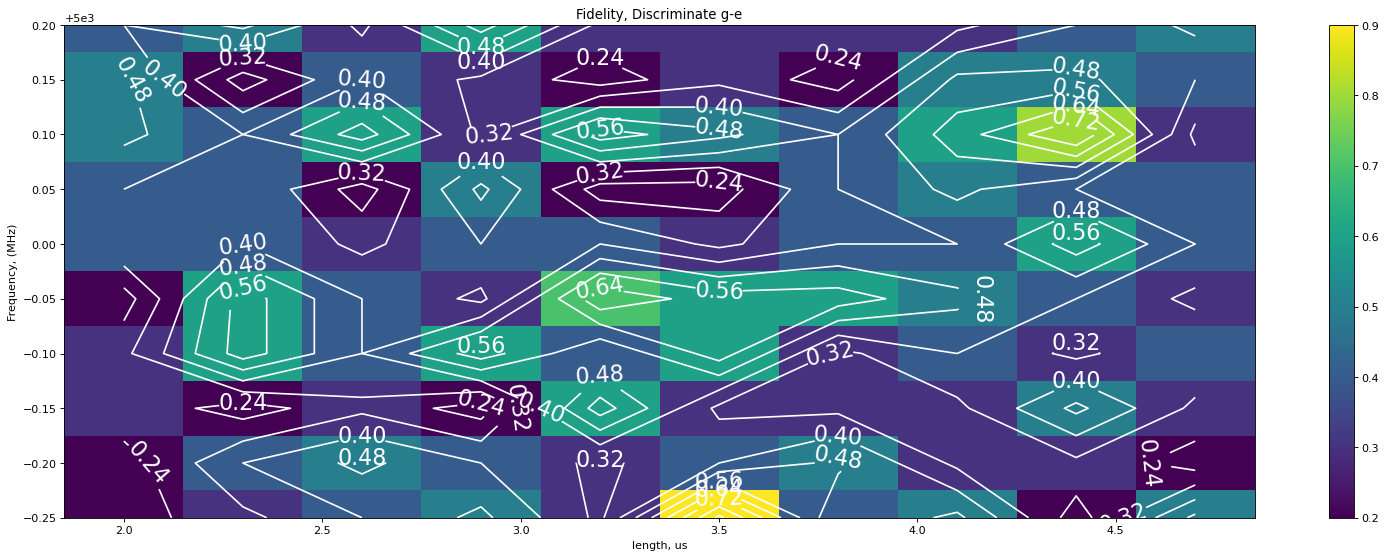

In [66]:
fid_Array =np.zeros([freq_steps,length_steps])
for index_freq in range(freq_steps):
    for index_length in range(length_steps):
        I_g = I_g_array[index_freq][0][index_length][0]
        Q_g = Q_g_array[index_freq][0][index_length][0]
        I_e = I_e_array[index_freq][0][index_length][0]
        Q_e = Q_e_array[index_freq][0][index_length][0]
        vec_I = np.mean(I_e) - np.mean(I_g)
        vec_Q = np.mean(Q_e) - np.mean(Q_g)
        gstate = (I_g - np.mean(I_g))*vec_I + (Q_g - np.mean(Q_g))*vec_Q
        estate = (I_e - np.mean(I_g))*vec_I + (Q_e - np.mean(Q_g))*vec_Q
        gstate = gstate / abs(vec_I+1j*vec_Q)**2
        estate = estate / abs(vec_I+1j*vec_Q)**2

        th_min = min(gstate)
        th_max = max(estate)
        th_list = np.linspace(th_min,th_max,1000)
        fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
        fid_Array[index_freq,index_length] = max(fidelity)*2-1

freqs_list = np.zeros(freq_steps)
lengths_list = np.zeros(length_steps)
for length in range(gain_steps):
    lengths_list[length] = length_start + length_step_size*length
for freq in range(freq_steps):
    freqs_list[freq] = freq_start + freq_step_size*freq

plt.figure(figsize=(24, 8), dpi=80)
figA = plt.pcolormesh(lengths_list,freqs_list,fid_Array)
figB = plt.contour(lengths_list,freqs_list,fid_Array, 10 ,colors='w',interpolation='none')
plt.clabel(figB, figB.levels, inline=True, fontsize=20)
plt.xlabel(r"length, us")
plt.ylabel(r"Frequency, (MHz)")
plt.title(r"Fidelity, Discriminate g-e")
plt.colorbar(figA)
plt.show()
#plt.savefig("FidwithoutJPA.png",dpi=300,bbox_inches='tight')